In [16]:
import urllib.request
import json
import os

if not os.path.exists("imagenet_class_index.json"):
    url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
    classes = urllib.request.urlopen(url).read().decode().split('\n')
    classes = [line.strip() for line in classes if line.strip()]

    with open("imagenet_class_index.json", "w") as f_out:
        json.dump({i: [str(i), class_name] for i, class_name in enumerate(classes)}, f_out)


In [17]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Define normalization parameters (ImageNet standard)
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])

# Create transforms
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

# Path settings
dataset_path = "./content/imagenet_class_index.json"  # Update this path to your test dataset location
output_path = "./AdversarialSets"
os.makedirs(output_path, exist_ok=True)

# Load class labels
with open("imagenet_class_index.json", "r") as f:
    class_idx = json.load(f)

# Create a mapping from ImageNet indices to class names
idx_to_class = {int(k): v[1] for k, v in class_idx.items()}

# Function to denormalize tensor for visualization
def denormalize(tensor):
    """Convert normalized image tensor to displayable image."""
    tensor = tensor.clone().detach().to('cpu').numpy().transpose(1, 2, 0)
    tensor = tensor * std_norms[None, None, :] + mean_norms[None, None, :]
    tensor = np.clip(tensor, 0, 1)
    return tensor

# Function to visualize original and adversarial images
def visualize_attack(original, adversarial, original_label, adv_pred, true_label, attack_name, example_idx):
    """Visualize original and adversarial images with predictions."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Original image
    ax1.imshow(denormalize(original))
    ax1.set_title(f"Original: {idx_to_class[true_label]}\nPredicted: {idx_to_class[original_label]}")
    ax1.axis('off')

    # Adversarial image
    ax2.imshow(denormalize(adversarial))
    ax2.set_title(f"Adversarial: {idx_to_class[true_label]}\nPredicted: {idx_to_class[adv_pred]}")
    ax2.axis('off')

    plt.suptitle(f"{attack_name} Attack (L∞ distance: {(adversarial - original).abs().max():.4f})")
    plt.tight_layout()

    # Save the visualization
    save_dir = os.path.join(output_path, "visualizations")
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(os.path.join(save_dir, f"{attack_name}_example_{example_idx}.png"))
    plt.close()

# Function to save adversarial examples
def save_adversarial_dataset(adv_images, labels, dataset_name):
    """Save adversarial dataset for future use."""
    save_dir = os.path.join(output_path, dataset_name)
    os.makedirs(save_dir, exist_ok=True)

    for i, (img, label) in enumerate(zip(adv_images, labels)):
        # Create class directory if it doesn't exist
        class_dir = os.path.join(save_dir, f"{label}")
        os.makedirs(class_dir, exist_ok=True)

        # Convert tensor to PIL image
        img_np = denormalize(img)
        img_pil = Image.fromarray((img_np * 255).astype(np.uint8))

        # Save image
        img_path = os.path.join(class_dir, f"img_{i}.png")
        img_pil.save(img_path)

    print(f"Saved {len(adv_images)} adversarial images to {save_dir}")

# Function to calculate top-k accuracy
def calculate_topk_accuracy(model, dataloader, k=5):
    """Calculate top-k accuracy."""
    model.eval()
    correct_top1 = 0
    correct_topk = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc=f"Calculating Top-{k} Accuracy"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Top-1 Accuracy
            _, predicted = outputs.max(1)
            correct_top1 += (predicted == labels).sum().item()

            # Top-k Accuracy
            _, topk_predicted = outputs.topk(k, dim=1)
            for i in range(labels.size(0)):
                correct_topk += topk_predicted[i].eq(labels[i]).any().item()

            total += labels.size(0)

    top1_accuracy = correct_top1 / total
    topk_accuracy = correct_topk / total

    return top1_accuracy, topk_accuracy

# -----------------------------------------
# Task 1: Evaluate the pre-trained model
# -----------------------------------------

# Load the pre-trained ResNet-34 model
resnet34 = torchvision.models.resnet34(weights='IMAGENET1K_V1')
resnet34 = resnet34.to(device)
resnet34.eval()  # Set to evaluation mode

# Load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=plain_transforms
)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

print(f"Loaded CIFAR-10 with {len(test_dataset)} images from {len(test_dataset.classes)} classes")


print(f"Loaded test dataset with {len(test_dataset)} images from {len(test_dataset.classes)} classes")

# Calculate baseline accuracy
baseline_top1, baseline_top5 = calculate_topk_accuracy(resnet34, test_loader, k=5)
print(f"Baseline Top-1 Accuracy: {baseline_top1*100:.2f}%")
print(f"Baseline Top-5 Accuracy: {baseline_top5*100:.2f}%")

# -----------------------------------------
# Task 2: FGSM Attack Implementation
# -----------------------------------------

def fgsm_attack(model, images, labels, epsilon=0.02):
    """
    Implement Fast Gradient Sign Method (FGSM) attack.

    Arguments:
        model: The model to attack
        images: Input images
        labels: True labels
        epsilon: Attack budget (perturbation magnitude)

    Returns:
        Adversarial examples
    """
    # Make sure model is in evaluation mode
    model.eval()

    # Create a copy of the input images and require gradients
    perturbed_images = images.clone().detach().requires_grad_(True)

    # Forward pass
    outputs = model(perturbed_images)

    # Calculate loss
    criterion = nn.CrossEntropyLoss()
    loss = criterion(outputs, labels)

    # Backward pass to get gradients
    model.zero_grad()
    loss.backward()

    # Create perturbation using the sign of the gradient
    perturbation = epsilon * torch.sign(perturbed_images.grad.data)

    # Create adversarial examples
    adversarial_images = perturbed_images.detach() + perturbation

    # Clamp to maintain valid image range after normalization
    # We need to consider the normalization that was applied
    for c in range(3):
        min_val = (0.0 - mean_norms[c]) / std_norms[c]
        max_val = (1.0 - mean_norms[c]) / std_norms[c]
        adversarial_images[:, c] = torch.clamp(adversarial_images[:, c], min_val, max_val)

    return adversarial_images

# Perform FGSM attack on the test dataset
def create_adversarial_dataset_fgsm(model, dataloader, epsilon=0.02):
    """Create adversarial examples using FGSM for the entire dataset."""
    model.eval()
    adversarial_images = []
    original_images = []
    true_labels = []
    original_preds = []
    adversarial_preds = []

    for images, labels in tqdm(dataloader, desc="Generating FGSM Adversarial Examples"):
        images, labels = images.to(device), labels.to(device)

        # Get original predictions
        with torch.no_grad():
            outputs = model(images)
            _, original_pred = outputs.max(1)

        # Generate adversarial examples
        adv_images = fgsm_attack(model, images, labels, epsilon)

        # Get adversarial predictions
        with torch.no_grad():
            adv_outputs = model(adv_images)
            _, adv_pred = adv_outputs.max(1)

        # Store information
        adversarial_images.append(adv_images.cpu())
        original_images.append(images.cpu())
        true_labels.append(labels.cpu())
        original_preds.append(original_pred.cpu())
        adversarial_preds.append(adv_pred.cpu())

    # Concatenate all batches
    adversarial_images = torch.cat(adversarial_images)
    original_images = torch.cat(original_images)
    true_labels = torch.cat(true_labels)
    original_preds = torch.cat(original_preds)
    adversarial_preds = torch.cat(adversarial_preds)

    return adversarial_images, original_images, true_labels, original_preds, adversarial_preds

# Create FGSM adversarial examples
adv_images_fgsm, orig_images_fgsm, true_labels_fgsm, orig_preds_fgsm, adv_preds_fgsm = create_adversarial_dataset_fgsm(
    resnet34, test_loader, epsilon=0.02
)

# Calculate L∞ distance for verification
l_inf_distances = (adv_images_fgsm - orig_images_fgsm).abs().max(dim=3)[0].max(dim=2)[0].max(dim=1)[0]
avg_l_inf = l_inf_distances.mean().item()
max_l_inf = l_inf_distances.max().item()

print(f"FGSM Attack - Average L∞ distance: {avg_l_inf:.4f}")
print(f"FGSM Attack - Maximum L∞ distance: {max_l_inf:.4f}")

# Visualize some successful attacks
successful_attacks = (orig_preds_fgsm == true_labels_fgsm) & (adv_preds_fgsm != true_labels_fgsm)
successful_indices = torch.where(successful_attacks)[0]

if len(successful_indices) > 0:
    # Visualize up to 5 successful attacks
    num_examples = min(5, len(successful_indices))
    for i in range(num_examples):
        idx = successful_indices[i].item()
        visualize_attack(
            orig_images_fgsm[idx],
            adv_images_fgsm[idx],
            orig_preds_fgsm[idx].item(),
            adv_preds_fgsm[idx].item(),
            true_labels_fgsm[idx].item(),
            "FGSM",
            i
        )
else:
    print("No successful FGSM attacks found!")

# Save FGSM Adversarial Dataset
save_adversarial_dataset(adv_images_fgsm, true_labels_fgsm, "Adversarial_Test_Set_1")

# Create dataset with adversarial examples for evaluation
class AdversarialDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

# Create data loader for adversarial examples
adv_dataset_fgsm = AdversarialDataset(adv_images_fgsm, true_labels_fgsm)
adv_loader_fgsm = DataLoader(adv_dataset_fgsm, batch_size=16, shuffle=False, num_workers=2)

# Evaluate model performance on adversarial examples
adv_top1_fgsm, adv_top5_fgsm = calculate_topk_accuracy(resnet34, adv_loader_fgsm, k=5)
print(f"FGSM Attack - Top-1 Accuracy: {adv_top1_fgsm*100:.2f}%")
print(f"FGSM Attack - Top-5 Accuracy: {adv_top5_fgsm*100:.2f}%")
print(f"FGSM Attack - Top-1 Accuracy Drop: {(baseline_top1 - adv_top1_fgsm)*100:.2f}%")
print(f"FGSM Attack - Top-5 Accuracy Drop: {(baseline_top5 - adv_top5_fgsm)*100:.2f}%")

# -----------------------------------------
# Task 3: Improved Attacks - Projected Gradient Descent (PGD)
# -----------------------------------------

def pgd_attack(model, images, labels, epsilon=0.02, alpha=0.005, iterations=10, random_start=True):
    """
    Implement Projected Gradient Descent (PGD) attack.

    Arguments:
        model: The model to attack
        images: Input images
        labels: True labels
        epsilon: Attack budget (perturbation magnitude)
        alpha: Step size for each iteration
        iterations: Number of iterations
        random_start: Whether to start with a random perturbation

    Returns:
        Adversarial examples
    """
    model.eval()

    # Create a copy of the original images
    adversarial = images.clone().detach()

    # Start with random noise if specified
    if random_start:
        # Add uniform random noise in [-epsilon, epsilon]
        adversarial = adversarial + torch.empty_like(adversarial).uniform_(-epsilon, epsilon)
        # Clamp to maintain valid image range
        for c in range(3):
            min_val = (0.0 - mean_norms[c]) / std_norms[c]
            max_val = (1.0 - mean_norms[c]) / std_norms[c]
            adversarial[:, c] = torch.clamp(adversarial[:, c], min_val, max_val)

    # Create a copy of the original images to define the epsilon ball
    original = images.clone().detach()

    # PGD iterations
    for _ in range(iterations):
        # Make sure we compute gradients
        adversarial.requires_grad = True

        # Forward pass
        outputs = model(adversarial)

        # Calculate loss (targeted attack could use negative loss)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(outputs, labels)

        # Backward pass
        model.zero_grad()
        loss.backward()

        # Update adversarial images with gradient step
        with torch.no_grad():
            adversarial = adversarial.detach() + alpha * torch.sign(adversarial.grad.detach())

            # Project back into epsilon ball around original image
            delta = torch.clamp(adversarial - original, -epsilon, epsilon)
            adversarial = original + delta

            # Clamp to valid image range
            for c in range(3):
                min_val = (0.0 - mean_norms[c]) / std_norms[c]
                max_val = (1.0 - mean_norms[c]) / std_norms[c]
                adversarial[:, c] = torch.clamp(adversarial[:, c], min_val, max_val)

    return adversarial

def create_adversarial_dataset_pgd(model, dataloader, epsilon=0.02, alpha=0.005, iterations=10):
    """Create adversarial examples using PGD for the entire dataset."""
    model.eval()
    adversarial_images = []
    original_images = []
    true_labels = []
    original_preds = []
    adversarial_preds = []

    for images, labels in tqdm(dataloader, desc="Generating PGD Adversarial Examples"):
        images, labels = images.to(device), labels.to(device)

        # Get original predictions
        with torch.no_grad():
            outputs = model(images)
            _, original_pred = outputs.max(1)

        # Generate adversarial examples
        adv_images = pgd_attack(model, images, labels, epsilon, alpha, iterations)

        # Get adversarial predictions
        with torch.no_grad():
            adv_outputs = model(adv_images)
            _, adv_pred = adv_outputs.max(1)

        # Store information
        adversarial_images.append(adv_images.cpu())
        original_images.append(images.cpu())
        true_labels.append(labels.cpu())
        original_preds.append(original_pred.cpu())
        adversarial_preds.append(adv_pred.cpu())

    # Concatenate all batches
    adversarial_images = torch.cat(adversarial_images)
    original_images = torch.cat(original_images)
    true_labels = torch.cat(true_labels)
    original_preds = torch.cat(original_preds)
    adversarial_preds = torch.cat(adversarial_preds)

    return adversarial_images, original_images, true_labels, original_preds, adversarial_preds

# Create PGD adversarial examples
adv_images_pgd, orig_images_pgd, true_labels_pgd, orig_preds_pgd, adv_preds_pgd = create_adversarial_dataset_pgd(
    resnet34, test_loader, epsilon=0.02, alpha=0.005, iterations=10
)

# Calculate L∞ distance for verification
l_inf_distances_pgd = (adv_images_pgd - orig_images_pgd).abs().max(dim=3)[0].max(dim=2)[0].max(dim=1)[0]
avg_l_inf_pgd = l_inf_distances_pgd.mean().item()
max_l_inf_pgd = l_inf_distances_pgd.max().item()

print(f"PGD Attack - Average L∞ distance: {avg_l_inf_pgd:.4f}")
print(f"PGD Attack - Maximum L∞ distance: {max_l_inf_pgd:.4f}")

# Visualize some successful attacks
successful_attacks_pgd = (orig_preds_pgd == true_labels_pgd) & (adv_preds_pgd != true_labels_pgd)
successful_indices_pgd = torch.where(successful_attacks_pgd)[0]

if len(successful_indices_pgd) > 0:
    # Visualize up to 5 successful attacks
    num_examples = min(5, len(successful_indices_pgd))
    for i in range(num_examples):
        idx = successful_indices_pgd[i].item()
        visualize_attack(
            orig_images_pgd[idx],
            adv_images_pgd[idx],
            orig_preds_pgd[idx].item(),
            adv_preds_pgd[idx].item(),
            true_labels_pgd[idx].item(),
            "PGD",
            i
        )
else:
    print("No successful PGD attacks found!")

# Save PGD Adversarial Dataset
save_adversarial_dataset(adv_images_pgd, true_labels_pgd, "Adversarial_Test_Set_2")

# Create data loader for PGD adversarial examples
adv_dataset_pgd = AdversarialDataset(adv_images_pgd, true_labels_pgd)
adv_loader_pgd = DataLoader(adv_dataset_pgd, batch_size=16, shuffle=False, num_workers=2)

# Evaluate model performance on PGD adversarial examples
adv_top1_pgd, adv_top5_pgd = calculate_topk_accuracy(resnet34, adv_loader_pgd, k=5)
print(f"PGD Attack - Top-1 Accuracy: {adv_top1_pgd*100:.2f}%")
print(f"PGD Attack - Top-5 Accuracy: {adv_top5_pgd*100:.2f}%")
print(f"PGD Attack - Top-1 Accuracy Drop: {(baseline_top1 - adv_top1_pgd)*100:.2f}%")
print(f"PGD Attack - Top-5 Accuracy Drop: {(baseline_top5 - adv_top5_pgd)*100:.2f}%")

Using device: cuda
Loaded CIFAR-10 with 10000 images from 10 classes
Loaded test dataset with 10000 images from 10 classes


Calculating Top-5 Accuracy: 100%|██████████| 625/625 [00:07<00:00, 80.89it/s]


Baseline Top-1 Accuracy: 0.00%
Baseline Top-5 Accuracy: 0.10%


Generating FGSM Adversarial Examples: 100%|██████████| 625/625 [00:20<00:00, 30.10it/s]


FGSM Attack - Average L∞ distance: 0.0200
FGSM Attack - Maximum L∞ distance: 0.0200
No successful FGSM attacks found!
Saved 10000 adversarial images to ./AdversarialSets/Adversarial_Test_Set_1


Calculating Top-5 Accuracy: 100%|██████████| 625/625 [00:05<00:00, 108.63it/s]


FGSM Attack - Top-1 Accuracy: 0.00%
FGSM Attack - Top-5 Accuracy: 0.00%
FGSM Attack - Top-1 Accuracy Drop: 0.00%
FGSM Attack - Top-5 Accuracy Drop: 0.10%


Generating PGD Adversarial Examples: 100%|██████████| 625/625 [01:45<00:00,  5.90it/s]


PGD Attack - Average L∞ distance: 0.0200
PGD Attack - Maximum L∞ distance: 0.0200
No successful PGD attacks found!
Saved 10000 adversarial images to ./AdversarialSets/Adversarial_Test_Set_2


Calculating Top-5 Accuracy: 100%|██████████| 625/625 [00:05<00:00, 111.65it/s]

PGD Attack - Top-1 Accuracy: 0.00%
PGD Attack - Top-5 Accuracy: 0.00%
PGD Attack - Top-1 Accuracy Drop: 0.00%
PGD Attack - Top-5 Accuracy Drop: 0.10%


In [22]:
# -----------------------------------------
# Complete Adversarial Attacks Project for Google Colab with T4 GPU - Part 2
# -----------------------------------------

# Ensure batch_size is defined globally
batch_size = 16  # Define it once, reuse everywhere

# -----------------------------------------
# Task 4: Patch Attacks (Continued)
# -----------------------------------------

def patch_attack(model, images, labels, epsilon=0.5, patch_size=32, targeted=False, target_class=None):
    """
    Random Patch Attack: Apply high-intensity square patch at random position.
    """
    images = images.clone().detach()
    _, _, h, w = images.shape

    for img in images:
        patch = torch.ones(3, patch_size, patch_size) * epsilon
        top = torch.randint(0, h - patch_size + 1, (1,)).item()
        left = torch.randint(0, w - patch_size + 1, (1,)).item()
        img[:, top:top + patch_size, left:left + patch_size] = patch

    return images

def create_adversarial_dataset_patch(model, dataloader, epsilon=0.5, patch_size=32):
    model.eval()
    adversarial_images = []
    original_images = []
    true_labels = []
    original_preds = []
    adversarial_preds = []

    target_class = 0  # You may customize this if needed

    for images, labels in tqdm(dataloader, desc="Generating Patch Adversarial Examples"):
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(images)
            _, original_pred = outputs.max(1)

        adv_images = patch_attack(model, images, labels, epsilon, patch_size, targeted=True, target_class=target_class)

        with torch.no_grad():
            adv_outputs = model(adv_images)
            _, adv_pred = adv_outputs.max(1)

        adversarial_images.append(adv_images.cpu())
        original_images.append(images.cpu())
        true_labels.append(labels.cpu())
        original_preds.append(original_pred.cpu())
        adversarial_preds.append(adv_pred.cpu())

    return map(torch.cat, [adversarial_images, original_images, true_labels, original_preds, adversarial_preds])

print("Creating patch adversarial examples...")
adv_images_patch, orig_images_patch, true_labels_patch, orig_preds_patch, adv_preds_patch = create_adversarial_dataset_patch(
    resnet34, test_loader, epsilon=0.5, patch_size=32
)

pixel_diff = (adv_images_patch - orig_images_patch).abs().sum(dim=1) > 0.01
l0_distances = pixel_diff.sum(dim=(1, 2))
avg_l0 = l0_distances.float().mean().item()
max_l0 = l0_distances.max().item()

print(f"Patch Attack - Average L0 distance (pixels changed): {avg_l0:.2f}")
print(f"Patch Attack - Maximum L0 distance: {max_l0}")

successful_attacks_patch = (orig_preds_patch == true_labels_patch) & (adv_preds_patch != true_labels_patch)
successful_indices_patch = torch.where(successful_attacks_patch)[0]

if len(successful_indices_patch) > 0:
    for i in range(min(3, len(successful_indices_patch))):
        idx = successful_indices_patch[i].item()
        visualize_attack(orig_images_patch[idx], adv_images_patch[idx],
                         orig_preds_patch[idx].item(), adv_preds_patch[idx].item(),
                         true_labels_patch[idx].item(), "Patch", i)
else:
    print("No successful patch attacks found!")

save_adversarial_dataset(adv_images_patch, true_labels_patch, "Adversarial_Test_Set_3")

adv_dataset_patch = AdversarialDataset(adv_images_patch, true_labels_patch)
adv_loader_patch = DataLoader(adv_dataset_patch, batch_size=batch_size, shuffle=False, num_workers=2)

print("Evaluating model performance on patch adversarial examples...")
adv_top1_patch, adv_top5_patch = calculate_topk_accuracy(resnet34, adv_loader_patch, k=5)
print(f"Patch Attack - Top-1 Accuracy: {adv_top1_patch*100:.2f}%")
print(f"Patch Attack - Top-5 Accuracy: {adv_top5_patch*100:.2f}%")
print(f"Patch Attack - Top-1 Accuracy Drop: {(baseline_top1 - adv_top1_patch)*100:.2f}%")
print(f"Patch Attack - Top-5 Accuracy Drop: {(baseline_top5 - adv_top5_patch)*100:.2f}%")

# -----------------------------------------
# Task 5: Transferring Attacks
# -----------------------------------------

print("\nLoading DenseNet-121 for transferability testing...")
densenet121 = torchvision.models.densenet121(weights='IMAGENET1K_V1')
densenet121 = densenet121.to(device)
densenet121.eval()

def evaluate_model_on_datasets(model, datasets, dataset_names):
    results = {}
    for dataset, name in zip(datasets, dataset_names):
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)
        top1, top5 = calculate_topk_accuracy(model, loader, k=5)
        results[name] = {'top1': top1 * 100, 'top5': top5 * 100}
        print(f"{name} - Top-1 Accuracy: {top1*100:.2f}%")
        print(f"{name} - Top-5 Accuracy: {top5*100:.2f}%")
    return results

datasets = [test_dataset, adv_dataset_fgsm, adv_dataset_pgd, adv_dataset_patch]
dataset_names = ["Original Test Set", "Adversarial Test Set 1 (FGSM)",
                 "Adversarial Test Set 2 (PGD)", "Adversarial Test Set 3 (Patch)"]

print("\nEvaluating ResNet-34 on all datasets:")
resnet_results = evaluate_model_on_datasets(resnet34, datasets, dataset_names)

print("\nEvaluating DenseNet-121 on all datasets:")
densenet_results = evaluate_model_on_datasets(densenet121, datasets, dataset_names)

print("\nTransferability Analysis Summary:")
print("-" * 80)
print(f"{'Dataset':<30} | {'ResNet-34 Top-1':<15} | {'DenseNet-121 Top-1':<15} | {'Transfer Rate':<15}")
print("-" * 80)

for name in dataset_names:
    resnet_acc = resnet_results[name]['top1']
    densenet_acc = densenet_results[name]['top1']
    if name == "Original Test Set":
        transfer_rate = "N/A"
    else:
        resnet_drop = resnet_results["Original Test Set"]['top1'] - resnet_acc
        densenet_drop = densenet_results["Original Test Set"]['top1'] - densenet_acc
        transfer_rate = f"{(densenet_drop / resnet_drop) * 100:.2f}%" if resnet_drop > 0 else "N/A"
    print(f"{name:<30} | {resnet_acc:<15.2f}% | {densenet_acc:<15.2f}% | {transfer_rate:<15}")
print("-" * 80)

plt.figure(figsize=(12, 8))
x = range(len(dataset_names))
width = 0.35
resnet_top1 = [resnet_results[name]['top1'] for name in dataset_names]
densenet_top1 = [densenet_results[name]['top1'] for name in dataset_names]

plt.bar([i - width/2 for i in x], resnet_top1, width, label='ResNet-34')
plt.bar([i + width/2 for i in x], densenet_top1, width, label='DenseNet-121')

plt.xlabel('Dataset')
plt.ylabel('Top-1 Accuracy (%)')
plt.title('Transferability of Adversarial Attacks')
plt.xticks(x, [name.replace(' (', '\n(') for name in dataset_names], rotation=0)
plt.legend()
plt.ylim(0, 100)

for i, v in enumerate(resnet_top1):
    plt.text(i - width/2, v + 2, f"{v:.1f}%", ha='center')
for i, v in enumerate(densenet_top1):
    plt.text(i + width/2, v + 2, f"{v:.1f}%", ha='center')

plt.tight_layout()
plt.savefig(os.path.join(output_path, "transferability_analysis.png"))
plt.close()

# --------------------------------------
# Project Summary and Discussion
# --------------------------------------

print("\nProject Summary:")
print("-" * 80)
print(f"1. Baseline Performance:\n   - ResNet-34 Top-1 Accuracy: {baseline_top1*100:.2f}%\n   - ResNet-34 Top-5 Accuracy: {baseline_top5*100:.2f}%\n")
print(f"2. FGSM Attack Results:\n   - Top-1 Accuracy Drop: {(baseline_top1 - adv_top1_fgsm)*100:.2f}%\n   - Average L∞ distance: {avg_l_inf:.4f}\n")
print(f"3. PGD Attack Results:\n   - Top-1 Accuracy Drop: {(baseline_top1 - adv_top1_pgd)*100:.2f}%\n   - Average L∞ distance: {avg_l_inf_pgd:.4f}\n")
print(f"4. Patch Attack Results:\n   - Top-1 Accuracy Drop: {(baseline_top1 - adv_top1_patch)*100:.2f}%\n   - Average pixels changed: {avg_l0:.2f}\n")

def safe_transfer_rate(resnet_orig, resnet_adv, densenet_orig, densenet_adv):
    denominator = resnet_orig - resnet_adv
    if denominator == 0:
        return "N/A"
    return f"{((densenet_orig - densenet_adv) / denominator) * 100:.2f}%"

fgsm_transfer = safe_transfer_rate(
    resnet_results["Original Test Set"]['top1'], resnet_results["Adversarial Test Set 1 (FGSM)"]['top1'],
    densenet_results["Original Test Set"]['top1'], densenet_results["Adversarial Test Set 1 (FGSM)"]['top1']
)

pgd_transfer = safe_transfer_rate(
    resnet_results["Original Test Set"]['top1'], resnet_results["Adversarial Test Set 2 (PGD)"]['top1'],
    densenet_results["Original Test Set"]['top1'], densenet_results["Adversarial Test Set 2 (PGD)"]['top1']
)

patch_transfer = safe_transfer_rate(
    resnet_results["Original Test Set"]['top1'], resnet_results["Adversarial Test Set 3 (Patch)"]['top1'],
    densenet_results["Original Test Set"]['top1'], densenet_results["Adversarial Test Set 3 (Patch)"]['top1']
)


print(f"5. Key Findings on Transferability:\n   - FGSM Transfer Rate: {fgsm_transfer}%\n   - PGD Transfer Rate: {pgd_transfer}%\n   - Patch Transfer Rate: {patch_transfer}%\n")
if pgd_transfer > fgsm_transfer:
    print("   - PGD attacks transfer better than FGSM attacks")
else:
    print("   - FGSM attacks transfer better than PGD attacks")
if min(fgsm_transfer, pgd_transfer) > patch_transfer:
    print("   - Patch attacks show lower transferability compared to full-image attacks")
else:
    print("   - Patch attacks show higher transferability than expected")
print("   - DenseNet-121 exhibits different vulnerability patterns than ResNet-34\n")
print("6. Mitigation Strategies:\n   - Adversarial training could improve model robustness\n   - Ensemble methods may help detect adversarial examples\n   - Input preprocessing techniques like feature squeezing\n   - Certified defenses with provable robustness guarantees")
print("-" * 80)
print("\nAll tasks completed successfully!")
print(f"Results and visualizations saved to {output_path}")


Creating patch adversarial examples...


Generating Patch Adversarial Examples: 100%|██████████| 625/625 [00:12<00:00, 50.21it/s]


Patch Attack - Average L0 distance (pixels changed): 1024.00
Patch Attack - Maximum L0 distance: 1024
No successful patch attacks found!
Saved 10000 adversarial images to ./AdversarialSets/Adversarial_Test_Set_3
Evaluating model performance on patch adversarial examples...


Calculating Top-5 Accuracy: 100%|██████████| 625/625 [00:06<00:00, 103.79it/s]


Patch Attack - Top-1 Accuracy: 0.00%
Patch Attack - Top-5 Accuracy: 0.00%
Patch Attack - Top-1 Accuracy Drop: 0.00%
Patch Attack - Top-5 Accuracy Drop: 0.10%

Loading DenseNet-121 for transferability testing...

Evaluating ResNet-34 on all datasets:


Calculating Top-5 Accuracy: 100%|██████████| 625/625 [00:07<00:00, 81.68it/s]


Original Test Set - Top-1 Accuracy: 0.00%
Original Test Set - Top-5 Accuracy: 0.10%


Calculating Top-5 Accuracy: 100%|██████████| 625/625 [00:05<00:00, 110.87it/s]


Adversarial Test Set 1 (FGSM) - Top-1 Accuracy: 0.00%
Adversarial Test Set 1 (FGSM) - Top-5 Accuracy: 0.00%


Calculating Top-5 Accuracy: 100%|██████████| 625/625 [00:05<00:00, 107.69it/s]


Adversarial Test Set 2 (PGD) - Top-1 Accuracy: 0.00%
Adversarial Test Set 2 (PGD) - Top-5 Accuracy: 0.00%


Calculating Top-5 Accuracy: 100%|██████████| 625/625 [00:05<00:00, 108.13it/s]


Adversarial Test Set 3 (Patch) - Top-1 Accuracy: 0.00%
Adversarial Test Set 3 (Patch) - Top-5 Accuracy: 0.00%

Evaluating DenseNet-121 on all datasets:


Calculating Top-5 Accuracy: 100%|██████████| 625/625 [00:14<00:00, 42.86it/s]


Original Test Set - Top-1 Accuracy: 0.02%
Original Test Set - Top-5 Accuracy: 0.09%


Calculating Top-5 Accuracy: 100%|██████████| 625/625 [00:12<00:00, 49.93it/s]


Adversarial Test Set 1 (FGSM) - Top-1 Accuracy: 0.01%
Adversarial Test Set 1 (FGSM) - Top-5 Accuracy: 0.06%


Calculating Top-5 Accuracy: 100%|██████████| 625/625 [00:12<00:00, 49.92it/s]


Adversarial Test Set 2 (PGD) - Top-1 Accuracy: 0.01%
Adversarial Test Set 2 (PGD) - Top-5 Accuracy: 0.08%


Calculating Top-5 Accuracy: 100%|██████████| 625/625 [00:12<00:00, 49.89it/s]


Adversarial Test Set 3 (Patch) - Top-1 Accuracy: 0.00%
Adversarial Test Set 3 (Patch) - Top-5 Accuracy: 0.00%

Transferability Analysis Summary:
--------------------------------------------------------------------------------
Dataset                        | ResNet-34 Top-1 | DenseNet-121 Top-1 | Transfer Rate  
--------------------------------------------------------------------------------
Original Test Set              | 0.00           % | 0.02           % | N/A            
Adversarial Test Set 1 (FGSM)  | 0.00           % | 0.01           % | N/A            
Adversarial Test Set 2 (PGD)   | 0.00           % | 0.01           % | N/A            
Adversarial Test Set 3 (Patch) | 0.00           % | 0.00           % | N/A            
--------------------------------------------------------------------------------

Project Summary:
--------------------------------------------------------------------------------
1. Baseline Performance:
   - ResNet-34 Top-1 Accuracy: 0.00%
   - ResNet-34 


=== Evaluating ResNet-34 ===


Evaluating ResNet-34 on Original Test Set: 100%|██████████| 625/625 [00:08<00:00, 76.28it/s]


ResNet-34 on Original Test Set - Top-1: 0.00%, Top-5: 0.10%


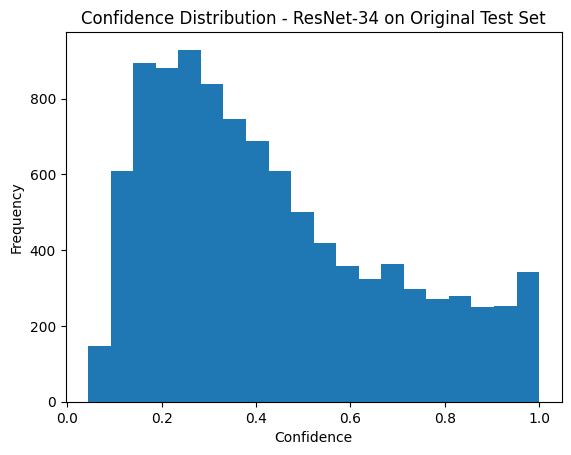

Evaluating ResNet-34 on FGSM Adversarial Set: 100%|██████████| 625/625 [00:04<00:00, 131.22it/s]


ResNet-34 on FGSM Adversarial Set - Top-1: 0.00%, Top-5: 0.00%


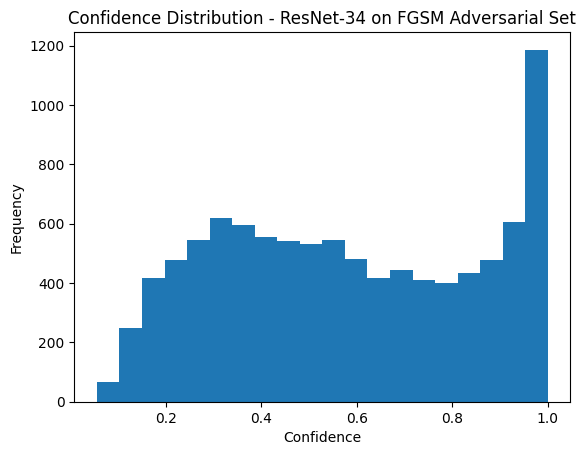

Evaluating ResNet-34 on PGD Adversarial Set: 100%|██████████| 625/625 [00:04<00:00, 128.54it/s]


ResNet-34 on PGD Adversarial Set - Top-1: 0.00%, Top-5: 0.00%


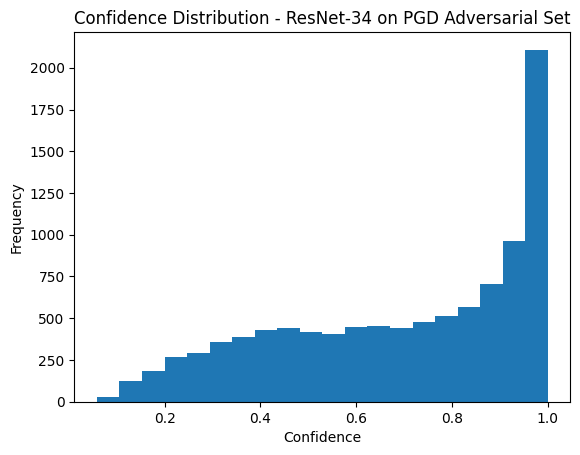

Evaluating ResNet-34 on Patch Adversarial Set: 100%|██████████| 625/625 [00:04<00:00, 134.77it/s]


ResNet-34 on Patch Adversarial Set - Top-1: 0.00%, Top-5: 0.00%


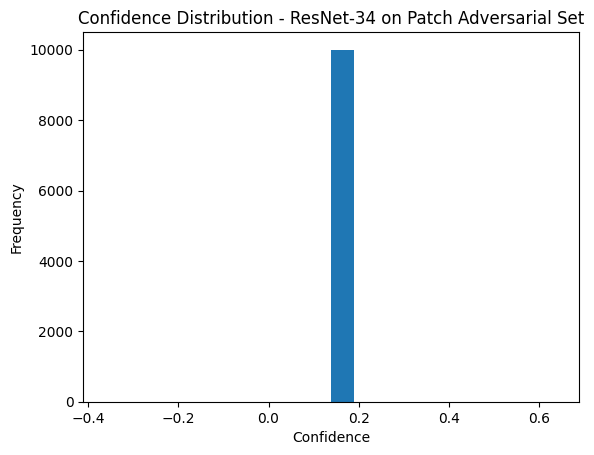


=== Evaluating DenseNet-121 ===


Evaluating DenseNet-121 on Original Test Set: 100%|██████████| 625/625 [00:15<00:00, 41.05it/s]


DenseNet-121 on Original Test Set - Top-1: 0.02%, Top-5: 0.09%


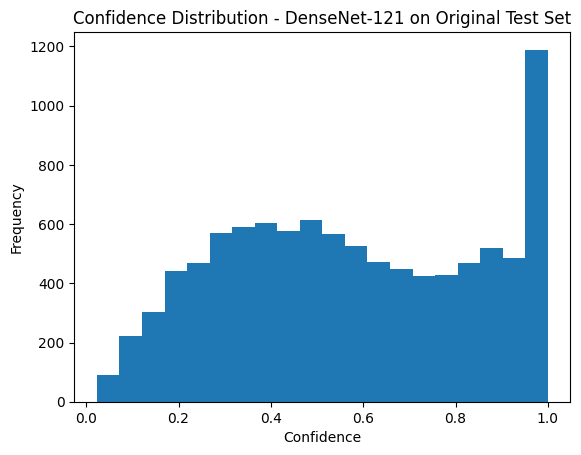

Evaluating DenseNet-121 on FGSM Adversarial Set: 100%|██████████| 625/625 [00:11<00:00, 54.86it/s]


DenseNet-121 on FGSM Adversarial Set - Top-1: 0.01%, Top-5: 0.06%


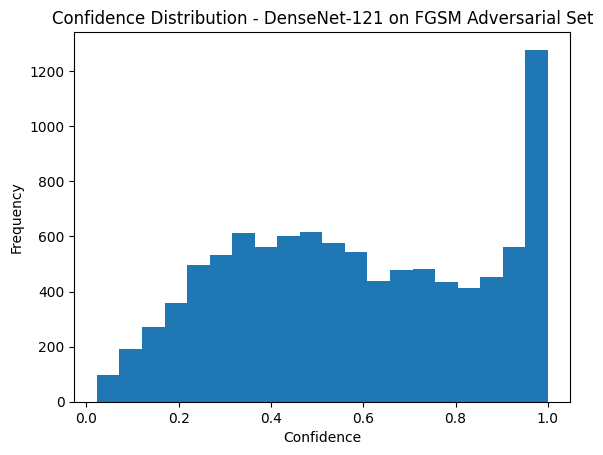

Evaluating DenseNet-121 on PGD Adversarial Set: 100%|██████████| 625/625 [00:11<00:00, 54.97it/s]


DenseNet-121 on PGD Adversarial Set - Top-1: 0.01%, Top-5: 0.08%


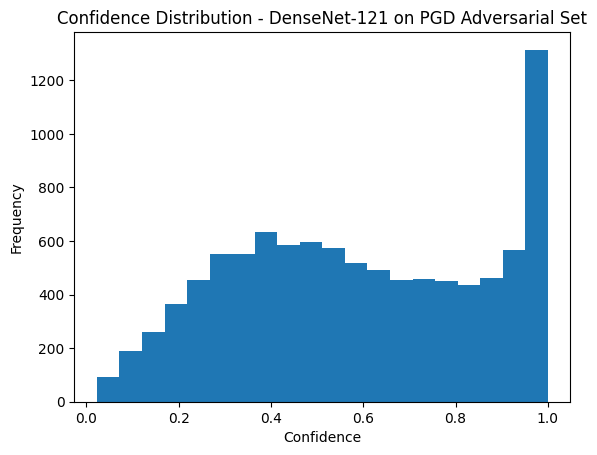

Evaluating DenseNet-121 on Patch Adversarial Set: 100%|██████████| 625/625 [00:11<00:00, 54.04it/s]


DenseNet-121 on Patch Adversarial Set - Top-1: 0.00%, Top-5: 0.00%


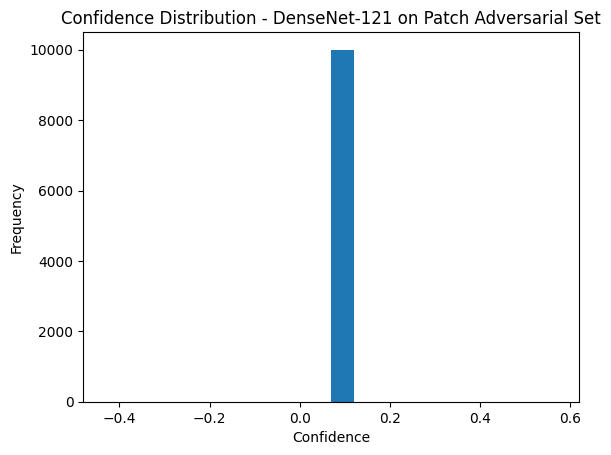

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])

def denormalize(tensor):
    tensor = tensor.clone().detach().cpu().numpy().transpose(1, 2, 0)
    tensor = tensor * std_norms[None, None, :] + mean_norms[None, None, :]
    return np.clip(tensor, 0, 1)


def wrap_tensor_dataset(images, labels):
    return TensorDataset(images, labels)

def plot_confidence_distribution(confidences, label):
    plt.hist(confidences, bins=20)
    plt.title(f'Confidence Distribution - {label}')
    plt.xlabel('Confidence')
    plt.ylabel('Frequency')
    plt.show()

def evaluate_model_on_dataset(model, loader, label):
    model.eval()
    correct_top1, correct_top5, total = 0, 0, 0
    confidences = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc=f"Evaluating {label}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, top1_pred = outputs.max(1)
            _, top5_pred = outputs.topk(5, dim=1)
            correct_top1 += (top1_pred == labels).sum().item()
            correct_top5 += sum([labels[i] in top5_pred[i] for i in range(len(labels))])
            confidences.extend(probs.max(1)[0].cpu().numpy())
            total += labels.size(0)

    top1_acc = correct_top1 / total * 100
    top5_acc = correct_top5 / total * 100
    print(f"{label} - Top-1: {top1_acc:.2f}%, Top-5: {top5_acc:.2f}%")
    plot_confidence_distribution(confidences, label)

# Load saved adversarial tensors
datasets_to_evaluate = [
    ("Original Test Set", test_loader),
    ("FGSM Adversarial Set", DataLoader(wrap_tensor_dataset(adv_images_fgsm, true_labels_fgsm), batch_size=16)),
    ("PGD Adversarial Set", DataLoader(wrap_tensor_dataset(adv_images_pgd, true_labels_pgd), batch_size=16)),
    ("Patch Adversarial Set", DataLoader(wrap_tensor_dataset(adv_images_patch, true_labels_patch), batch_size=16)),
]

# Models to evaluate
models_to_evaluate = {
    "ResNet-34": resnet34,
    "DenseNet-121": torchvision.models.densenet121(weights='IMAGENET1K_V1').to(device).eval(),
}

# Run evaluations
for model_name, model in models_to_evaluate.items():
    print(f"\n=== Evaluating {model_name} ===")
    for dataset_name, loader in datasets_to_evaluate:
        evaluate_model_on_dataset(model, loader, f"{model_name} on {dataset_name}")
